![header](https://i.imgur.com/I4ake6d.jpg)

# How to plot current vectors using Python

<div class="alert alert-block alert-info">

<b>Note:</b> This notebook will teach you how to plot current vectors using Python.<br/>
It follows the example from [this article](https://help.marine.copernicus.eu/en/articles/7044577-how-to-plot-current-vectors-using-python).

Specifically, in this tutorial, we will display the current vectors as functions of the variables uo and vo for the following product and dataset:  

- Alternatively use this? https://rdrr.io/github/hvillalo/satin2/man/quiver.html
- Need to deal with auth using the guide from [here](https://help.marine.copernicus.eu/en/articles/5182598-how-to-consume-the-opendap-api-and-cas-sso-using-python)
- Product: [GLOBAL_ANALYSISFORECAST_PHY_001_024](https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_PHY_001_024/description)  
    - [Manual](https://catalogue.marine.copernicus.eu/documents/PUM/CMEMS-GLO-PUM-001-024.pdf)
- Dataset: cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i  
    - May be more from US gov here [1](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NCEI-GOCD) [2](https://www.ncei.noaa.gov/products/global-ocean-currents-database), manual [here](https://www.ncei.noaa.gov/access/data/global-ocean-currents-database/documents/qcscd_manual_v1.pdf)

This script can be used with any other dataset containing the variables `uo` and `vo`, no matter how large the geographical area is. 

## Import libraries

Run this cell to import the libraries.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

If you don't already have the above packages installed on your machine, you can execute the following code in a code cell: : 
```
!pip install xarray
```
To access the `mpl_toolkits` package, you must install Basemap, by running :
```
!pip install basemap
```

## Open your dataset

In this part you can open your netcdf file stored locally on your machine.

You can also choose to open the dataset of your choice with OPeNDAP and apply your subset, you will find the procedure to follow [in this article](https://help.marine.copernicus.eu/en/articles/5182598-how-to-consume-the-opendap-api-and-cas-sso-using-python).

In [2]:
# Open dataset
ds = xr.open_dataset('C:/YOUR/DIRECTORY/cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 361, latitude: 199, time: 20)
Coordinates:
  * longitude  (longitude) float32 9.0 9.083 9.167 9.25 ... 38.83 38.92 39.0
  * latitude   (latitude) float32 -43.0 -42.92 -42.83 ... -26.67 -26.58 -26.5
    depth      float32 ...
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-01-05T18:00:00
Data variables:
    uo         (time, latitude, longitude) float32 ...
    vo         (time, latitude, longitude) float32 ...
Attributes: (12/13)
    title:                         Instantaneous fields for product GLOBAL_AN...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_ANALYSISFORECAST_PHY_001_024
    source:                        MERCATOR GLO12
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...

## Run the script

The first thing to do is to extract the surface data, at the date and depth for which you want to display the vectors.
Then we'll isolate the `uo` and `vo` variables to calculate the intensity.

In [4]:
# Select surface data at the nearest time to January 1, 2023 at 12:00:00
ds_surface = ds.sel(time="2023-01-01T12:00:00", method='nearest')

u = ds_surface.uo.values
v = ds_surface.vo.values

# Calculate the intensity
intensity = np.sqrt(u**2 + v**2)

Please note that if your dataset has several `depth` dimension values, you must select the depth level in the same way as the date.

Ex: `ds_surface = ds.sel(time="2023-01-01T12:00:00", depth = 0, method='nearest')`

Now let's configure the parameters of our future map:

<Figure size 1800x800 with 0 Axes>

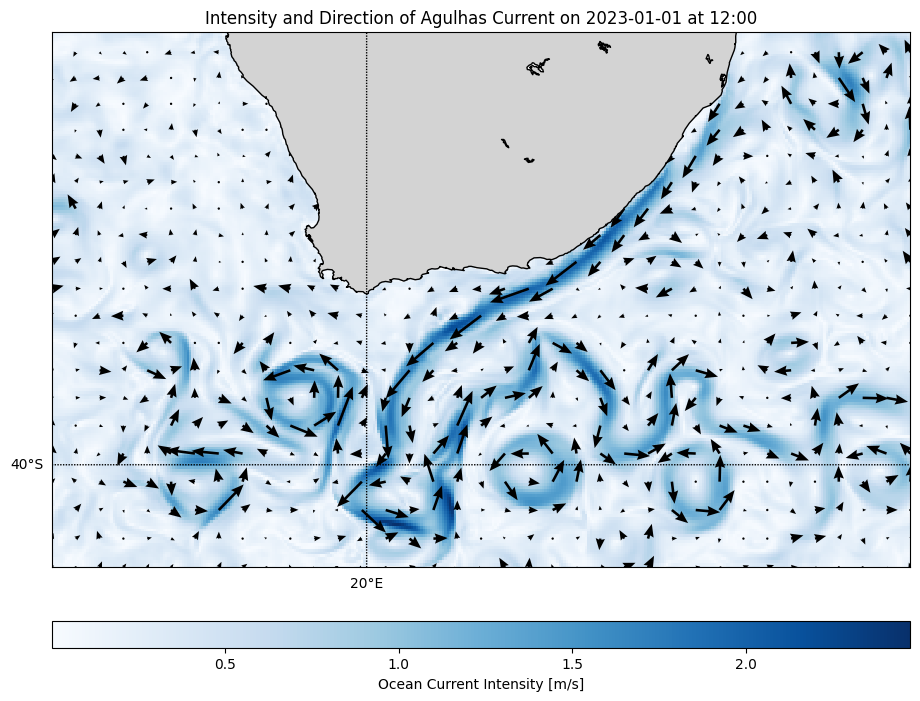

In [5]:
# Set the size of the map
width_inch = 18
height_inch = 8
fig = plt.figure(figsize=(width_inch, height_inch))

# Configure the map projection using Basemap
m = Basemap(projection='mill',
            llcrnrlon=ds_surface.longitude.min().values,
            llcrnrlat=ds_surface.latitude.min().values,
            urcrnrlon=ds_surface.longitude.max().values,
            urcrnrlat=ds_surface.latitude.max().values, resolution='i')

# Convert coordinates to a grid
lon, lat = np.meshgrid(ds_surface.longitude.values, ds_surface.latitude.values)

# Create a new figure
fig, ax = plt.subplots(figsize=(width_inch, height_inch))

# Use pcolormesh to display current intensity as a background
m.pcolormesh(lon, lat, intensity, cmap='Blues', latlon=True)

# Adjust the length and width of the arrows based on intensity
scale_factor = 0.05  # Adjust this factor to control the arrow size
u_scaled = u * scale_factor
v_scaled = v * scale_factor

# Define a slice to skip drawing some of the quiver arrows to reduce clutter
skip = (slice(None, None, 10), slice(None, None, 10))

# Use the quiver function to display current vectors with their direction and intensity
m.quiver(lon[skip], lat[skip], u_scaled[skip], v_scaled[skip], color='black', latlon=True, scale=2, width=0.003, headwidth=4)

# Draw coastlines, continents, and meridians/parallels
m.drawcoastlines()
m.fillcontinents(color='lightgray')
m.drawparallels(np.arange(-80., 81., 20.), labels=[True, False, False, False])
m.drawmeridians(np.arange(-180., 181., 20.), labels=[False, False, False, True])

# Add a color scale for ocean current intensity
cbar = m.colorbar(location='bottom', pad='10%')
cbar.set_label('Ocean Current Intensity [m/s]')

# Add a title
plt.title('Intensity and Direction of Agulhas Current on 2023-01-01 at 12:00')

# Show the map
plt.show()

***

## Conclusion

<div class="alert alert-block alert-success">
    <b>CONGRATULATIONS!</b><br>

You have successfully displayed the direction and intensity of marine currents! 😃   
    
That's it for this tutorial, don't hesitate to contact the Copernicus Support in case you have any trouble or question about this notebook. We'd also be happy to get feedback from you about how we could improve this tutorial, if you managed to follow it all along and so on 😊   
    
You can find other tutorials in our [e-learning materials](https://marine.copernicus.eu/services/user-learning-services/tutorials) page and also some useful [Use Cases](https://marine.copernicus.eu/services/use-cases).
</div>